# KNN Information-Based Analysis and Improvement
This notebook explores how proximity-weighted KNN accuracy relates to the information content of variable subsets, and proposes algorithms (GIW-KNN and LMI-KNN) to improve accuracy using only KNN and information-theoretic functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import random

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
print(f'Train size: {X_train.shape}, Test size: {X_test.shape}')

Train size: (455, 30), Test size: (114, 30)


In [3]:
from sklearn.metrics.pairwise import euclidean_distances
def proximity_weighted_knn(X_train, y_train, X_test, k=5, kernel='inverse'):
    dists = euclidean_distances(X_test, X_train)
    preds = []
    for i in range(X_test.shape[0]):
        dist_i = dists[i]
        idx = np.argsort(dist_i)[:k]
        neigh_d = dist_i[idx]
        neigh_y = y_train[idx]
        if kernel == 'inverse':
            weights = 1 / (neigh_d + 1e-6)
        elif kernel == 'gaussian':
            sigma = np.std(neigh_d)
            weights = np.exp(-(neigh_d ** 2) / (2 * sigma**2 + 1e-6))
        else:
            weights = np.ones_like(neigh_d)
        classes = np.unique(y_train)
        class_weights = {c: np.sum(weights[neigh_y == c]) for c in classes}
        preds.append(max(class_weights, key=class_weights.get))
    return np.array(preds)

In [5]:
def subset_information_analysis(X_train, y_train, X_test, y_test, subset_sizes=[2,4,8,12], n_random=20, k=5):
    results = []
    MI_feats = mutual_info_classif(X_train, y_train, random_state=42)
    feature_MI = pd.Series(MI_feats, index=X_train.columns)
    for s in subset_sizes:
        print(f'Subset size: {s}')
        for _ in tqdm(range(n_random)):
            subset = random.sample(list(X_train.columns), s)
            Xtr_sub, Xte_sub = X_train[subset], X_test[subset]
            preds = proximity_weighted_knn(Xtr_sub.values, y_train, Xte_sub.values, k=k)
            acc = accuracy_score(y_test, preds)
            mi_sum = feature_MI[subset].sum()
            mi_avg = feature_MI[subset].mean()
            results.append({'subset_size': s, 'accuracy': acc, 'MI_sum': mi_sum, 'MI_avg': mi_avg})
    return pd.DataFrame(results)

Subset size: 2


100%|██████████| 20/20 [00:00<00:00, 99.74it/s]


Subset size: 4


100%|██████████| 20/20 [00:00<00:00, 96.60it/s]


Subset size: 8


100%|██████████| 20/20 [00:00<00:00, 105.10it/s]


Subset size: 12


100%|██████████| 20/20 [00:00<00:00, 76.21it/s]


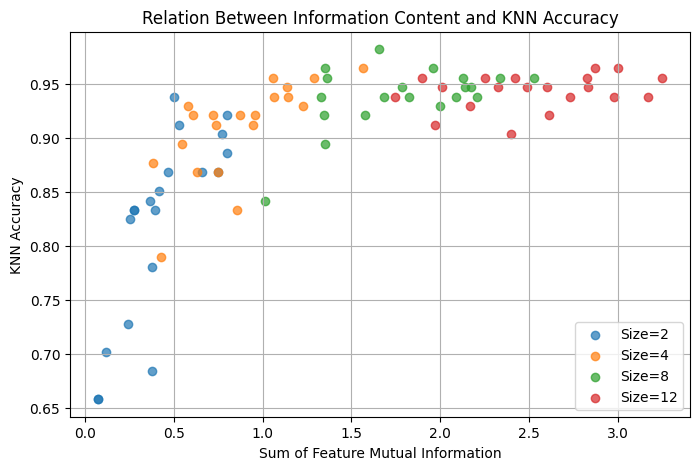

In [6]:
results_df = subset_information_analysis(X_train, y_train, X_test, y_test)
plt.figure(figsize=(8,5))
for s in sorted(results_df['subset_size'].unique()):
    subset_data = results_df[results_df['subset_size'] == s]
    plt.scatter(subset_data['MI_sum'], subset_data['accuracy'], label=f'Size={s}', alpha=0.7)
plt.xlabel('Sum of Feature Mutual Information')
plt.ylabel('KNN Accuracy')
plt.title('Relation Between Information Content and KNN Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def GIW_KNN(X_train, y_train, X_test, y_test, k=7, λ=0.5):
    MI_feats = mutual_info_classif(X_train, y_train, random_state=42)
    feature_MI = pd.Series(MI_feats, index=X_train.columns)
    p = X_train.shape[1]
    redundancy = np.zeros(p)
    for i in range(p):
        mi_sum = 0
        for j in range(p):
            if i != j:
                mi_sum += mutual_info_classif(X_train[[X_train.columns[i]]], X_train.iloc[:, j].round(), discrete_features=False, random_state=42)[0]
        redundancy[i] = mi_sum / (p - 1)
    raw = feature_MI / (1e-6 + λ * redundancy)
    weights = raw / raw.sum()
    def weighted_dist(a, b):
        return np.sqrt(np.sum(weights.values * (a - b)**2))
    preds = []
    for x in X_test.values:
        dists = np.array([weighted_dist(x, xi) for xi in X_train.values])
        idx = np.argsort(dists)[:k]
        neigh_d = dists[idx]
        neigh_y = y_train[idx]
        weights_inv = 1 / (neigh_d + 1e-6)
        classes = np.unique(y_train)
        class_scores = {c: np.sum(weights_inv[neigh_y == c]) for c in classes}
        preds.append(max(class_scores, key=class_scores.get))
    acc = accuracy_score(y_test, preds)
    return acc, weights

In [8]:
giw_acc, giw_weights = GIW_KNN(X_train, y_train, X_test, y_test)
print(f'GIW-KNN Accuracy (all variables): {giw_acc:.4f}')

GIW-KNN Accuracy (all variables): 0.9649


In [9]:
def LMI_KNN(X_train, y_train, X_test, y_test, base_weights, k0=30, alpha=0.6, T=2, candidate_k=[3,5,7,11]):
    weights = base_weights.copy()
    feature_names = X_train.columns
    for t in range(T):
        print(f'Iteration {t+1}/{T}')
        local_MI = np.zeros(len(feature_names))
        idx_samples = np.random.choice(len(X_train), size=min(200, len(X_train)), replace=False)
        for i, f in enumerate(feature_names):
            mi_vals = []
            for idx in idx_samples:
                x0 = X_train.iloc[idx].values
                dists = np.sqrt(np.sum(weights.values * (X_train.values - x0)**2, axis=1))
                neigh_idx = np.argsort(dists)[:k0]
                mi = mutual_info_classif(X_train.iloc[neigh_idx][[f]], y_train[neigh_idx], random_state=42)
                mi_vals.append(mi[0])
            local_MI[i] = np.mean(mi_vals)
        local_MI /= np.sum(local_MI) + 1e-6
        weights = alpha * weights + (1 - alpha) * pd.Series(local_MI, index=feature_names)
        weights /= weights.sum()
    preds = []
    for x in X_test.values:
        dists = np.sqrt(np.sum(weights.values * (X_train.values - x)**2, axis=1))
        H_k = []
        for k in candidate_k:
            idx = np.argsort(dists)[:k]
            neigh_y = y_train[idx]
            p = np.bincount(neigh_y) / len(neigh_y)
            H = -np.sum(p[p > 0] * np.log2(p[p > 0]))
            H_k.append(H)
        best_k = candidate_k[np.argmin(H_k)]
        idx = np.argsort(dists)[:best_k]
        neigh_y = y_train[idx]
        preds.append(np.argmax(np.bincount(neigh_y)))
    acc = accuracy_score(y_test, preds)
    return acc, weights

In [10]:
lmi_acc, lmi_weights = LMI_KNN(X_train, y_train, X_test, y_test, giw_weights)
base_knn = KNeighborsClassifier(n_neighbors=7, weights='distance').fit(X_train, y_train)
base_acc = base_knn.score(X_test, y_test)
print(f'Baseline KNN Accuracy: {base_acc:.4f}')
print(f'GIW-KNN Accuracy: {giw_acc:.4f}')
print(f'LMI-KNN Accuracy: {lmi_acc:.4f}')

Iteration 1/2
Iteration 2/2
Baseline KNN Accuracy: 0.9649
GIW-KNN Accuracy: 0.9649
LMI-KNN Accuracy: 0.9649
